## Procesamiento de Imágenes Digitales

Inteligencia Artificial 2025 I <br>
Examen Parcial, parte práctica de la evaluación (12 puntos).

**Integrantes:**

1.   Integrante 1: Stefano Imanol Ramírez Uribe
2.   Integrante 2: Jhiro Franky Cisneros Sanchez


Los objetivos de esta práctica son:

* Desarrollar y analizar rutinas de transformaciones puntuales en el procesamiento de imágenes.
* Repasar conceptos clave en el filtrado de imágenes y programar rutinas para suavizar y resaltar bordes.

## Requerimientos

Se necesita disponer del siguiente software:
* Python 3.X
* Las siguientes librerias científicas de Python: NumPy, SciPy, y Matplotlib.
* OpenCV.

# 1 Operadores basados en la primera derivada

La detección de bordes (Edge detection) es una técnica de procesamiento de imágenes para encontrar aquellos puntos en las imágenes que representan variaciones de brillo (cambios bruscos en los niveles de gris) o *bordes*. Tiene muchas aplicaciones para la segmentación de imágenes y la extracción de datos que se explicarán posteriormente en este curso.

Como se ha comentado, los bordes pueden definirse como transiciones entre regiones de la imagen que tienen diferentes niveles de gris (intensidades). De esta forma, el modelo unidimensional y continuo de un borde ideal es:

<img src="./imagenes/model_of_ideal_edge.PNG" width="600">

<!--<img src='https://drive.google.com/uc?export=view&id=1a0_1V5E6WytNFmrA-kZEcFNBBCMweTOs' width="600">-->

---

Sin embargo, en las imágenes reales ese modelo no es seguido exactamente por los bordes, ya que las imágenes son discretas y están corrompidas por el ruido.

Además, **la naturaleza de los bordes puede ser diversa**:
- bordes de oclusión
- diferente orientación de las superficies
- diferentes propiedades de reflectancia
- diferentes texturas
- efectos de iluminación: sombras, reflejos, etc.

### Tipos de error relacionados con la detección de bordes

Finding edges properly is not a straightforward task, as there exist different errors that can appear when applying edge detection techniques:
- **Detection error.** A good detector exhibits low ratio of false negative and false positive, that is:
  - Falsos negativos: Bordes existentes que no se detectan.
  - Falsos positivos: Objetos detectados que no son reales.
- **Error de localización.** Se detectan bordes, pero no están en la posición real y exacta.
- **Respuesta múltiple.** Se producen múltiples detecciones para la misma arista ( el borde es grueso).

La siguiente figura ilustra este tipo de errores.

<img src="./imagenes/edge_errors.jpg" width="400">


<!--<img src='https://drive.google.com/uc?export=view&id=1MLbgTBymqY07JzTArEfJONj8rPqAUpaR' width="400">-->

Por lo tanto, al diseñar un buen detector de bordes, el objetivo es lograr errores de detección y localización bajos, así como evitar respuestas múltiples.

### Operadores basados en la primera derivada (gradiente)

En este notebook cubriremos los operadores basados en la **primera derivada**, que intentan detectar bordes fijándose en las diferencias bruscas de intensidad en los píxeles vecinos. En la imagen inferior podemos ver dos funciones  $f(x)$
 (primera fila) y cómo sus derivadas (segunda fila) alcanzan sus valores máximos en los puntos donde los valores de las funciones cambian más bruscamente (alrededor de $x_o$).


<img src="./imagenes/first_derivative_of_continuous_function.PNG" width="500">$\\[10pt]$

<!--
<img src='https://drive.google.com/uc?export=view&id=1qFllASGI0vHwkMfXDGO6kM8aQS-xtmto' width="500">$\\[10pt]$
-->

Si se trata de una **función continua bidimensional** $f(x,y)$, su derivada es un *vector* (**gradiente**) definido como:$\\[10pt]$
$$
\nabla  f(x,y) =
\begin{bmatrix}
\frac{\partial}{\partial x}f(x,y) \\ \frac{\partial}{\partial y}f(x,y)
\end{bmatrix}
=
\begin{bmatrix}
f_x(x,y) \\
f_y(x,y)
\end{bmatrix}
$$

que apunta a la *dirección* de máxima variación (positiva) de $f(x,y)$:$\\[10pt]$

$$
\alpha(x,y) = \arctan \left(\frac{f_y(x,y)}{f_x(x,y)}\right)
$$

y tiene un *módulo* proporcional a la fuerza de esta variación:$\\[10pt]$

$$
|\nabla  f(x,y)| = \sqrt{(f_x(x,y))^2 + (f_y(x,y))^2} \approx |f_x(x,y)| + |f_y(x,y)|
$$

La siguiente imagen muestra ejemplos de vectores gradiente:$\\[10pt]$

<img src="./imagenes/gradient_examples.PNG" width="700">$\\[10pt]$


<!--
<img src='https://drive.google.com/uc?export=view&id=1udNDgpPvk6LbfOqG6tNsr0v6vaxAUT3f' width="700">$\\[10pt]$
-->

Concretamente, las técnicas basadas en la primera derivada exploradas aquí son:

- Aproximaciones discretas de un **operador de gradiente** (Sobel, Prewitt, Roberts, etc., Sección 1.1).
- El operador **Derivada del Gaussiano** (DroG) (apartado 1.2).


## Contexto del problema - Detección de bordes en imágenes médicas

La detección de bordes en imágenes médicas es de vital importancia para el diagnóstico de diferentes enfermedades (por ejemplo, la detección de células tumorales) en órganos humanos como pulmones y próstatas, convirtiéndose en un paso de pre procesamiento esencial en la segmentación de imágenes médicas.


<img src="./imagenes/hospital_clinico.jpg" width="400">

<!--
<img src='https://drive.google.com/uc?export=view&id=1G3v8hkH5TAy7QuLYf8vKikUqcGHMnUZD' width="400">
-->
En este contexto, *Hospital Clínico*, un hospital muy concurrido de Arequipa está solicitando a estudiantes de ingeniería locales que se unan a su equipo de investigación. Buscan una persona con conocimientos en procesamiento de imágenes y, para asegurarlo, han publicado 3 imágenes médicas: `medical_1.jpg`, `medical_2.jpg` y `medical_3.jpg`. Nos han pedido que realicemos una detección de bordes precisa en las tres imágenes, así como una explicación de cómo se ha realizado.

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib
from ipywidgets import interactive, fixed, widgets
from mpl_toolkits.mplot3d import Axes3D

matplotlib.rcParams['figure.figsize'] = (15.0, 15.0)


images_path = './imagenes/'
#images_path = '/content/drive/MyDrive/docencia/claseIA2024/pc2/elaboracion/imagenes/'

Para afrontar este reto, vamos a utilizar varios métodos de detección de bordes, que se probarán y compararán para determinar la mejor opción.

### **<span style="color:green"><b><i>Ejercicio 1: Observe y analice las imágenes</i></b></span>** (0.25 puntos)

En primer lugar, **visualice las imágenes proporcionadas** para tener una idea de lo que estamos tratando.

*Nota: Como la mayoría de las imágenes médicas no proporcionan información de color, vamos a utilizar la detección de bordes en imágenes en escala de grises.*

*Consejo: Se pueden seguir diferentes enfoques para la detección de bordes en imágenes en color, como la conversión al espacio de color YCrCb (que no se ve en ese notebook), o la detección de bordes en cada canal RGB.


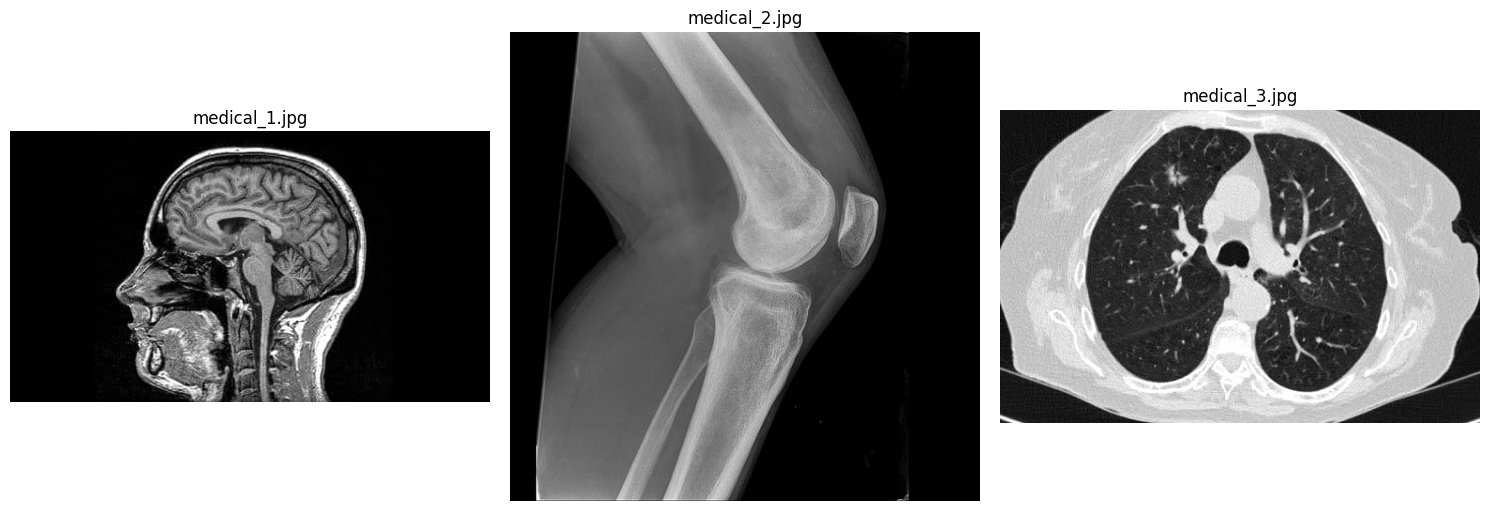

In [3]:
# Ejercicio 1
# Visualiza las imágenes proporcionadas en un gráfico 1x3 para ver de qué se trata
# Escribe tu código aquí

# Leer las imágenes en escala de grises
img1 = cv2.imread(images_path + 'medical_1.jpg', cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread(images_path + 'medical_2.jpg', cv2.IMREAD_GRAYSCALE)
img3 = cv2.imread(images_path + 'medical_3.jpg', cv2.IMREAD_GRAYSCALE)

# Mostrar las imágenes
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(img1, cmap='gray')
plt.title('medical_1.jpg')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(img2, cmap='gray')
plt.title('medical_2.jpg')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(img3, cmap='gray')
plt.title('medical_3.jpg')
plt.axis('off')

plt.tight_layout()
plt.show()


Llegados a este punto sabemos cómo realizar una aproximación discreta de un operador gradiente mediante la aplicación de una operación de convolución con dos kernels diferentes, esto es:

$$\nabla  F(x,y) =
\begin{bmatrix}
F \otimes H_C \\ F \otimes H_R
\end{bmatrix}$$

Pero, ¿cómo podríamos utilizar la salida de esos cálculos para detectar bordes? La siguiente figura lo aclara!


<img src="./imagenes/how_to_detect_edges_with_gradient_image2.png" width="350">

<!--
<img src='https://drive.google.com/uc?export=view&id=10NvwqVLVL7yqY9P5DyJDr8WuKGNQOpAP' width="350">
-->

**Tamaños de los Kernel**

Como ya se ha comentado, los kernels pueden ser de distinto tamaño, y ese tamaño afecta directamente a la calidad de la detección y la localización (por ejemplo, Sobel $3\times3$ o $5\times5$):
- Máscara pequeña:
  - localización más precisa (buena localización).
  - más afectada por el ruido (probablemente produce falsos positivos).
- Máscara grande:
  - localización menos precisa.
  - más resistente al ruido (buen detector).
  - mayor coste computacional ($O(N veces N)$)



## 1.1 Aproximaciones discretas de un operador gradiente

El primer grupo de métodos que vamos a explorar realiza una **aproximación discreta de un operador de gradiente** basada en las diferencias entre niveles de gris (intensidad). Por ejemplo:




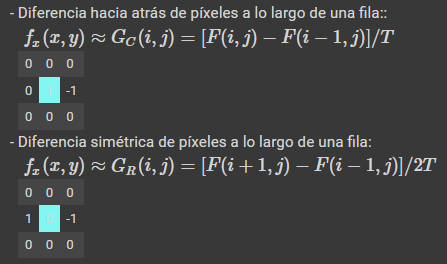

Estas aproximaciones se implementan típicamente mediante la convolución de la imagen con un par de máscaras $H_C$ (para columnas, detectando los bordes verticales) y $H_R$ (para filas, detectando los horizontales), es decir:

$$
G_R(i,j) = F(i,j) \otimes H_R(i,j) \\
G_C(i,j) = F(i,j) \otimes H_C(i,j)
$$

Quizás el operador más popular que hace esto es el de **Sobel**, aunque hay muchos de ellos que proporcionan resultados aceptables. Estos operadores utilizan los dos kernels antes mencionados (normalmente de tamaño $3\times3$ o $5\times5$) que se convolucionan con la imagen original para calcular aproximaciones de las derivadas.

Estos son algunos ejemplos (primera columna: nombre del operador; segunda: $H_R$; tercera columna: $H_C$):

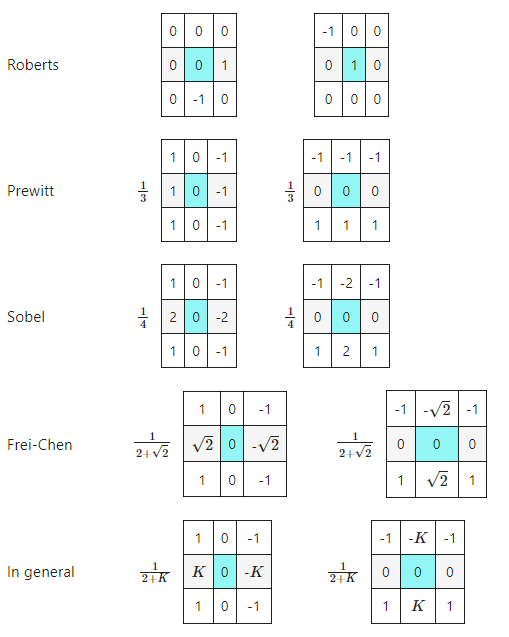




### **<span style="color:green"><b><i>Ejercicio 2:</i>  Jugar con las derivadas de Sobel</b></span>** (1.25 puntos)

Ahora que hemos adquirido una comprensión básica de estos métodos, vamos a emplear los núcleos de Sobel ($S_x,S_y$) para calcular ambas derivadas y mostrarlas junto con la imagen original (`medical_3.jpg`).

*Nótese que los valores de la imagen derivada pueden ser positivos **y negativos**, causados por los valores negativos en el kernel. Esto implica que la profundidad deseada de la imagen de destino (`ddepth`) tiene que ser al menos un tipo de datos con signo cuando se llama al método `filter2D()`.

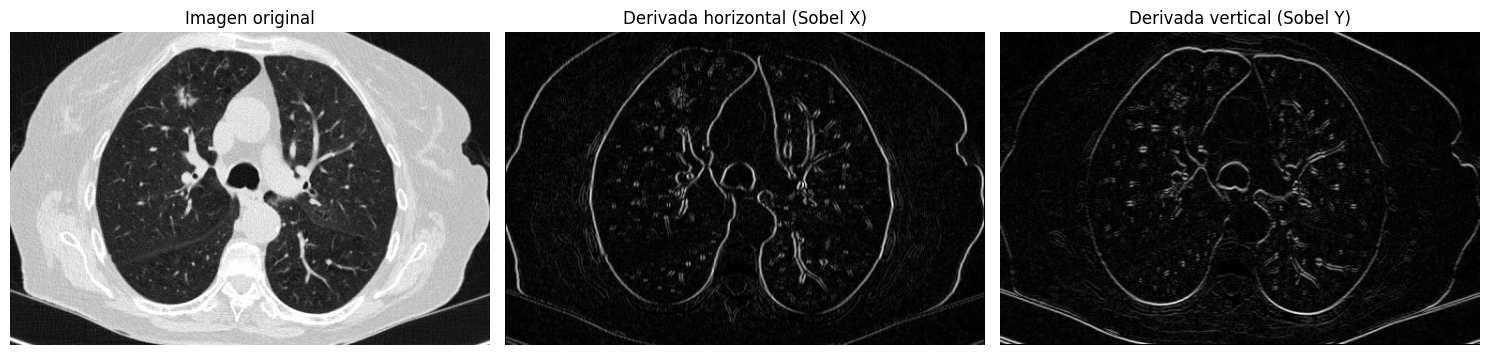

In [4]:
# Lee una de las imágenes, calcula ambas derivadas del kernel, aplícalas a la imagen (por separado) y muestra la imagen original y las derivadas en un gráfico 1x3.
# Escriba su código aquí

# Leer la imagen
img3 = cv2.imread(images_path + 'medical_3.jpg', cv2.IMREAD_GRAYSCALE)

# Define los kernels horizontal y vertical
sobel_x = (1/4) * np.array([[ 1,  0, -1],
                            [ 2,  0, -2],
                            [ 1,  0, -1]])

sobel_y = (1/4) * np.array([[-1, -2, -1],
                            [ 0,  0,  0],
                            [ 1,  2,  1]])

# Aplica la convolución
grad_x = cv2.filter2D(img3, cv2.CV_64F, sobel_x)
grad_y = cv2.filter2D(img3, cv2.CV_64F, sobel_y)

# ¡Y muéstralos!
grad_x = cv2.convertScaleAbs(grad_x)
grad_y = cv2.convertScaleAbs(grad_y)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(img3, cmap='gray')
plt.title('Imagen original')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(grad_x, cmap='gray')
plt.title('Derivada horizontal (Sobel X)')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(grad_y, cmap='gray')
plt.title('Derivada vertical (Sobel Y)')
plt.axis('off')

plt.tight_layout()
plt.show()


Una vez que hemos calculado ambas imágenes derivadas $G_C$ y $G_R$, podemos determinar la imagen completa del borde calculando la magnitud del gradiente de la imagen y luego binarizando el resultado:


$$|\nabla F(x,y)| = \sqrt{(F \otimes G_C)^2 + (F \otimes G_R)^2} \approx |F \otimes G_C| + |F \otimes G_R|$$

### **<span style="color:green"><b><i>Ejercicio 3a: Momento de detectar los bordes</i></b></span>**   (2 puntos, por 3a y 3b juntos)

Completa `edge_detection_chart()` que calcula la imagen de gradiente de una de entrada usando `kernel_h` y `kernel_v` (kernels para derivadas horizontales y verticales respectivamente) y **binariza la imagen resultante** (imagen final de bordes) usando `threshold`. A continuación, muestre en un gráfico de 1x3 `image`, la imagen de gradiente y, finalmente, ¡una imagen con los bordes detectados! (Sólo si `verbose` es True).

*Consejo: debería [normalizar](https://docs.opencv.org/2.4/modules/core/doc/operations_on_arrays.html#normalize) la imagen de gradiente antes de umbralizar.

In [5]:
# Ejercicio 3a
# Implementar una función que calcule el gradiente de una imagen, tomando también como entrada los kernels de convolución.
# También debe binarizar la imagen resultante usando un umbral.
# Muestra la imagen de entrada, la imagen de gradiente (normalizada) y la imagen de borde binarizada en un gráfico de 1x3 (si verbose = True)
def edge_detection_chart(image, kernel_h, kernel_v, threshold, verbose=False):
    """ Computed the gradient of the image, binarizes and display it.

        Args:
            image: Imagen de entrada
            kernel_h: kernel para la derivada horizontal
            kernel_v: kernel para la derivada vertical
            threshold: valor del umbral para la binarización
            verbose:  Sólo muestra imágenes si es True

        Returns:
            edges:  imagen binaria de los borde

    """

    # Calcular derivadas
    grad_x = cv2.filter2D(image, cv2.CV_64F, kernel_h)
    grad_y = cv2.filter2D(image, cv2.CV_64F, kernel_v)

    # Calcular gradiente
    gradient = np.sqrt(grad_x**2 + grad_y**2)

    #Normalizar gradiente
    gradient_norm = cv2.normalize(gradient, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    gradient_uint8 = gradient_norm.astype(np.uint8)

    # Umbral para obtener bordes
    _, edges = cv2.threshold(gradient_uint8, threshold, 255, cv2.THRESH_BINARY)

    if verbose:
        plt.figure(figsize=(18, 6))
        # Mostrar la imagen inicial
        plt.subplot(1, 3, 1)
        plt.imshow(image, cmap='gray')
        plt.title('Imagen original')
        plt.axis('off')

        # Mostrar la imagen del gradiente
        plt.subplot(1, 3, 2)
        plt.imshow(gradient_uint8, cmap='gray')
        plt.title('Gradiente (normalizado)')
        plt.axis('off')

        # Mostrar la imagen de los bordes
        plt.subplot(1, 3, 3)
        plt.imshow(edges, cmap='gray')
        plt.title(f'Bordes detectados (umbral={threshold})')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

    return edges


Puedes utilizar el siguiente código para **comprobar si tus resultados son correctos**:

In [6]:
image = np.array([[10,60,20],[60,22,74],[72,132,2]], dtype=np.uint8)

kernel_h = np.array([[1,0,-1],[2,0,-2],[1,0,-1]])*1/4
kernel_v = np.array([[-1,-2,-1],[0,0,0],[1,2,1]])*1/4

print(edge_detection_chart(image, kernel_h, kernel_v, 100))

[[  0   0   0]
 [255 255 255]
 [  0 255   0]]


<font color='blue'>**Salida esperada:**  </font>

    [[  0   0   0]
     [255 255 255]
     [  0 255   0]]

### **<span style="color:green"><b><i>Ejercicio 3b: Probando nuestro detector</i></b></span>**

Ahora **prueba el método implementado** con kernels Sobel de diferentes tamaños ($3\times3$, $5\times5$, ...) y con otros operadores (Roberts, Prewitt, ...).

In [22]:
# Ejercicio 3b
# Lee la imagen, establece tus kernels (Sobel, Roberts, Prewitt, etc.) e interactúa con el parámetro umbral.
# ¡Escribe tu código aquí!

# Leer la imagen
image = cv2.imread(images_path + 'medical_3.jpg', 0)

# Define los kernel (Sobel, Roberts, Prewitt, ...)

#--------------- Prewitt ---------------------
#kernel_h = (1/3) * np.array([[1, 0, -1],
#                             [1, 0, -1],
 #                            [1, 0, -1]])

#kernel_v = (1/3) * np.array([[-1, -1, -1],
 #                            [ 0,  0,  0],
 #                            [ 1,  1,  1]])

#-------------Roberts -----------------------
#kernel_h = np.array([[0,  0, 0],
#                     [0,  0, 1],
#                      [0, -1, 0]])

#kernel_v = np.array([[-1, 0, 0],
#                      [ 0, 1, 0],
#                     [ 0, 0, 0]])

# -------------- Sobel 3x3 --------------------
# kernel_h = (1/4) * np.array([[1, 0, -1],
#                              [2, 0, -2],
#                              [1, 0, -1]])

# kernel_v = (1/4) * np.array([[-1, -2, -1],
#                              [ 0,  0,  0],
#                              [ 1,  2,  1]])

# -------------- Sobel 5x5 --------------------
#kernel_h = (1/12) * np.array([[2,  1,  0, -1, -2],
 #                                [3,  2,  0, -2, -3],
 #                                [4,  3,  0, -3, -4],
 #                                [3,  2,  0, -2, -3],
 #                                [2,  1,  0, -1, -2]])

#kernel_v = (1/12) * np.array([[-2, -3, -4, -3, -2],
  #                               [-1, -2, -3, -2, -1],
  #                               [ 0,  0,  0,  0,  0],
   #                              [ 1,  2,  3,  2,  1],
   #                              [ 2,  3,  4,  3,  2]])

#---------------Frei-Chen -------------
sqrt2 = np.sqrt(2)
norm = 1 / (2 + sqrt2)
kernel_h = norm * np.array([[1, 0, -1],
                             [sqrt2, 0, -sqrt2],
                             [1, 0, -1]])

kernel_v = norm * np.array([[-1, -sqrt2, -1],
                             [ 0,     0,  0],
                             [ 1,  sqrt2, 1]])

#¡Interactúa con tu código!
interactive( edge_detection_chart, image=fixed(image), kernel_h=fixed(kernel_h), kernel_v=fixed(kernel_v), threshold=(0,255,10), verbose=fixed(True))

interactive(children=(IntSlider(value=120, description='threshold', max=255, step=10), Output()), _dom_classes…

### <font color="blue"><b><i>Pensándolo bien (1)</i></b></font>

Ahora, **responde a las siguientes preguntas**::

- - ¿Qué pasa si usamos un kernel más grande?
  
    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Pon tu respuesta aquí!</i></p>
    
- ¿Hay diferencias entre Sobel y otros operadores?
  
    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Pon tu respuesta aquí!</i></p>
    
- ¿Qué errores aparecen utilizando esos operadores?

    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Pon tu respuesta aquí!</i></p>
    
- ¿Por qué los kernels se suelen dividir por un número? (por ejemplo, $3\times3$ Sobel se divide por 4)

    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Pon tu respuesta aquí!</i></p>

## 1.2 Operador DroG

A pesar de la sencillez de las técnicas anteriores, presentan un notable inconveniente: su rendimiento está muy influenciado por el ruido de la imagen. Observando la siguiente figura podemos ver cómo, teniendo una función aparentemente no tan ruidosa (primera fila), en la que es fácil detectar un escalón (un cambio brusco en sus valores) alrededor de 1000, la respuesta de la derivada con ese nivel de ruido es tan grande como el propio escalón!$\\[5pt]$

<img src="./imagenes/example_of_derivative_of_noisy_function.PNG" width="600"><br />

<!--
<img src='https://drive.google.com/uc?export=view&id=1Df2SjeFXoDCif4NAOgmBgEh40nF2cfI4' width="600">
-->

<center><i>Fuente: S. Seitz</i></center>

¡Pero no todo está perdido! Una técnica de procesamiento de imágenes ya estudiada puede utilizarse para mitigar ese ruido: la **image smoothing** y más concretamente, el **filtrado gaussiano**. La idea básica es suavizar la imagen y luego aplicar un operador de gradiente, es decir, calcular $\frac{\partial}{\partial x}(f \otimes g)$. No sólo eso, esto se puede hacer de manera aún más eficiente gracias a la propiedad de la derivada de convolución:$\\[5pt]$


$$\frac{\partial}{\partial x}(f \otimes g) = f \otimes \frac{\partial}{\partial x}g
$$$\\[5pt]$

Es decir, precalcular los kernels resultantes de la convolución del filtrado Gaussisan y los de Sobel, y luego convolucionarlos con la imagen a procesar. Con eso nos ahorramos una operación!$\\[5pt]$

Esta combinación de suavizado y gradiente se suele llamar **Operador derivado del Gaussiano (DroG)**:$\\[5pt]$

$$
\nabla [f(x,y)\otimes g_\sigma(x,y)] =
f(x,y) \otimes \nabla [g_\sigma(x,y)] =
f(x,y) \otimes \text{DroG} (x,y)
$$

$$
DroG(x,y) =
\nabla \left[ g_\sigma (x,y) \right] =
\underbrace{\begin{bmatrix}
\frac{\partial}{\partial x}[g_\sigma(x)g_\sigma(y)] \\
\frac{\partial}{\partial y}[g_\sigma(x)g_\sigma(y)] \end{bmatrix}}_{\text{separability}} =
\underbrace{\begin{bmatrix} \frac{-xg_\sigma(x,y)}{\sigma^2} \\ \frac{-yg_\sigma(x,y)}{\sigma^2}\end{bmatrix}}_{g(x)'=-xg(x)/\sigma^2}
$$

Recordemos la expresión de la distribución gaussiana con 2 variables, donde la desviación típica $\sigma$ controla el grado de suavidad:


$$g_{\sigma}(x,y) = \frac{1}{2\pi\sigma^2}exp\left(-\frac{x^2+y^2}{2\sigma^2}\right)$$

Tenga en cuenta que la máscara o kernel DroG se crea una sola vez.

### **<span style="color:green"><b><i>Ejercicio 4: Aplicando DroG</i></b></span>** (1.5 puntos)

Nos gustaría probar esta técnica robusta de detección de bordes, así que completa el método `gaussian_kernel()` que construye un filtro Gaussiano y luego lo deriva, obteniendo la máscara DroG. Finalmente, llama a `edge_detection_chart()` usando esa máscara.

Sus entradas son:
- una imagen a procesar,
- el tamaño de apertura del kernel,
- la desviación estándar, y
- el umbral de binaritazión de la imagen de gradiente.

In [27]:
# Ejercicio 4
# Implementar una función que construya las máscaras DroG horizontales y verticales y llame a 'edge_detection_chart' usando esas máscaras.
# Inputs: una imagen, el tamaño de apertura del kernel, la desviación estándar gaussiana y el umbral para la binarización de la imagen de gradiente.
# Devuelve los kernels horizontal y vertical
def gaussian_kernel(image, w_kernel, sigma, threshold, verbose=False):
    """ Construye el operador DroG y llama a edge_detection_chart.

        Args:
            image:  Imagen de entrada
            w_kernel: Tamaño de apertura del kernel
            sigma: desviación estándar de la distribución gaussiana
            umbral: Valor umbral para la binarización
            verbose: Sólo muestra imágenes si es True

        Returns:
            kernel_h, kernel_v: Derivadas horizontal y vertical de DroG
    """
    # Crear filtro gaussiano
    half_size = w_kernel // 2
    x = np.arange(-half_size, half_size + 1)
    g = (1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-(x**2) / (2 * sigma**2))
    g_deriv = -x * g / sigma**2
    

    # Construir DroG
    drog_x = np.outer(g, g_deriv)  
    drog_y = np.outer(g_deriv, g)  


    # Llamar al gráfico de detección de bordes usando DroG
    edge_detection_chart(image, drog_x, drog_y, threshold, verbose=verbose)

    return drog_x, drog_y

Puedes utilizar el siguiente código para **comprobar si tus resultados son correctos**:

In [28]:
# Crear una imagen de entrada
image = np.array([[10,60,20],[60,22,74],[72,132,2]], dtype=np.uint8)

# Aplicar el kernel gaussiano
gaussian_kernel(image, w_kernel=3, sigma=1.2, threshold=100)

(array([[ 0.03832673,  0.        , -0.03832673],
        [ 0.05423735,  0.        , -0.05423735],
        [ 0.03832673,  0.        , -0.03832673]]),
 array([[ 0.03832673,  0.05423735,  0.03832673],
        [ 0.        ,  0.        ,  0.        ],
        [-0.03832673, -0.05423735, -0.03832673]]))

<font color='blue'>**Salida esperada:**  </font>

    (array([[ 0.03832673, -0.        , -0.03832673],
            [ 0.05423735, -0.        , -0.05423735],
            [ 0.03832673, -0.        , -0.03832673]]),
     array([[ 0.03832673,  0.05423735,  0.03832673],
            [-0.        , -0.        , -0.        ],
            [-0.03832673, -0.05423735, -0.03832673]]))

### <font color="blue"><b><i>Pensándolo bien (2)</i></b></font>

Ahora **prueba este método** y juega con los parámetros interactivos. Luego **contesta a las siguientes preguntas**:

- ¿Qué ocurre si se utiliza un kernel mayor?
  
    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Pon tu respuesta aquí!</i></p>

- ¿Qué tipo de errores aparecen y desaparecen al modificar sigma?
  
    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Pon tu respuesta aquí!</i></p>
    
- ¿Por qué el gradiente de la imagen tiene valores más bajos que el de la imagen original?  *Tip: [image normalization](https://stackoverflow.com/questions/40645985/opencv-python-normalize-image/42164670)*

    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Pon tu respuesta aquí!</i></p>
    
- Ahora que has probado diferentes técnicas, en tu opinión, ¿cuál es la mejor para este tipo de imágenes?

    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Pon tu respuesta aquí!</i></p>

In [20]:
# Leer la imagen
image = cv2.imread(images_path + 'medical_3.jpg', 0)

# Interactuar con los 3 parámetros
interactive(gaussian_kernel, image=fixed(image), w_kernel=(1,5,1), sigma=(0.4,5,0.5), threshold=(0,255,10), verbose=fixed(True))

interactive(children=(IntSlider(value=3, description='w_kernel', max=5, min=1), FloatSlider(value=2.4, descrip…

### **<span style="color:green"><b><i>Ejercicio 5: Medir la eficiencia</i></b></span>**  (0.75 puntos)

Por último, **se le pide** que compare el tiempo de ejecución de la creación de una máscara DroG utilizando su código anterior (combinando dos filtros gaussianos 1-D), con la creación de una máscara DroG utilizando un filtro gaussiano 2-D. *Utilice un tamaño de apertura grande (por ejemplo 500)*.

*Tip: [cómo medir el tiempo de ejecución en Python](https://stackoverflow.com/questions/14452145/how-to-measure-time-taken-between-lines-of-code-in-python)*

In [26]:
# Ejercicio 5

import time

print("Midiendo el tiempo de ejecucion necesario para  ...")

# Parámetros
w_kernel = 501
sigma = 1.5
# Iniciar temporizador
start_time_1d = time.time()
# Crear filtro gaussiano 1D
half_size = w_kernel // 2
x = np.arange(-half_size, half_size + 1)

g = (1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-(x**2) / (2 * sigma**2))
g_deriv = -x * g / sigma**2


# Construir DroG usando filtros Gaussianos 1D
drog_x_1d = np.outer(g, g_deriv)  # derivada respecto a x
drog_y_1d = np.outer(g_deriv, g)  # derivada respecto a y


# Detener temporizador
end_time_1d = time.time()
elapsed_time_1d = end_time_1d - start_time_1d

# Iniciar temporizador
start_time_2d = time.time()


# Crear filtro gaussiano 2D
x = np.arange(-half_size, half_size + 1)
y = np.arange(-half_size, half_size + 1)
xx, yy = np.meshgrid(x, y)

gauss2d = (1 / (2 * np.pi * sigma**2)) * np.exp(-(xx**2 + yy**2) / (2 * sigma**2))


# Construir DroG usando filtro Gaussiano 2D
drog_x_2d = -xx * gauss2d / sigma**2
drog_y_2d = -yy * gauss2d / sigma**2

# Detener temporizador
end_time_2d = time.time()
elapsed_time_2d = end_time_2d - start_time_2d

# Resultados
print(f"Tiempo con filtros Gaussianos 1D (separables): {elapsed_time_1d:.6f} segundos")
print(f"Tiempo con filtro Gaussiano 2D completo     : {elapsed_time_2d:.6f} segundos")

Midiendo el tiempo de ejecucion necesario para  ...
Tiempo con filtros Gaussianos 1D (separables): 0.003407 segundos
Tiempo con filtro Gaussiano 2D completo     : 0.016344 segundos


# 2 Operadores basados en la segunda derivada

Del mismo modo que podemos detectar bordes observando la imagen de gradiente (primera derivada), también es posible hacerlo analizando la salida de los operadores basados en la segunda derivada.

Los operadores basados en la primera derivada intentan detectar bordes buscando valores de magnitud elevada de dichas derivadas. Recordemos la figura mostrada en la sección anterior, que ilustra dos funciones continuas unidimensionales $f(x)$ y sus primeras derivadas.


<img src="./imagenes/second_derivative_of_continuous_function.PNG" width="400">

<!--
<img src='https://drive.google.com/uc?export=view&id=1E3a2z-S0hHPhu5ilpO6QSWO77EBghkRK' width="400">
-->

Añadimos ahora una tercera fila (c) que muestra sus segundas derivadas, y podemos comprobar cómo tales valores corresponden a... **cruces por cero!**. Es decir, una segunda derivada produce un cruce por cero en los puntos donde el gradiente presenta un máximo, por lo que podríamos detectar bordes buscando esos cruces.

Por desgracia, las cosas se complican un poco cuando pasamos a un espacio 2D (como las imágenes). ¿Por qué? Porque dependiendo de la orientación del borde, este cruce por cero puede pasar casi desapercibido (véase, por ejemplo, c):


<img src="./imagenes/second_derivatives_of_2D_functions.PNG" width="500">

<!--
<img src='https://drive.google.com/uc?export=view&id=1832wC_8Nki2UVTiDSjW4PAnE0CT68NW-' width="500">
-->


En este Notebook vamos a explorar dos métodos que se enfrentan a este problema y detectan bordes utilizando la segunda derivada. Estos son:

- **Operador laplaciano** (Sección 2.1)
- **Operador LoG** (Sección 2.2)

Además, también echaremos un vistazo a un algoritmo muy utilizado que es una combinación de diferentes técnicas: el **algoritmo Canny** (Sección 2.3).

## Contexto del problema - Detección de bordes para imágenes médicas

Desgraciadamente, no has sido aceptado (¡todavía!) por el equipo investigador del *Hospital Clínico* porque los resultados obtenidos en el Notebook anterior no eran tan buenos como se esperaba. De todas formas, te han mostrado los algoritmos que están utilizando actualmente para que puedas estudiarlo de cara a futuras entrevistas. ¡Vamos a echarle un vistazo!


<img src="./imagenes/hired.jpg" width="300">

<!--
<img src='https://drive.google.com/uc?export=view&id=11rIYViyLRGyzWO5CcTvQtAx7oVnygO8j' width="300">
-->

## 2.1  Operador de Laplace

Comparado con los detectores de bordes basados en la primera derivada, como el operador de Sobel, el operador de Laplace puede dar mejores resultados en la localización de bordes, ya que es
- un operador lineal
- robusto frente al ruido,
- preciso en la localización de objetos.

La idea subyacente es combinar segundas derivadas en direcciones perpendiculares. Así, se define como:

$$
\nabla^2 f(i,j) =
\frac{\partial^2}{\partial x^2}f(i,j) +
\frac{\partial^2}{\partial y^2}f(i,j)
$$

Nótese que, por definición, **devuelve un escalar**, no un vector como en el caso del gradiente. De hecho, el Laplaciano es la traza de la *matriz hessiana*, que caracteriza completamente la segunda derivada de una función:

$$
H(f) =
\begin{bmatrix}
\frac{\partial f^2}{\partial x^2} & \frac{\partial}{\partial x}\frac{\partial f}{\partial y} \\
\frac{\partial f}{\partial y}\frac{\partial f}{\partial x} & \frac{\partial f^2}{\partial y^2}
\end{bmatrix}
$$


### Implementación
Veamos ahora cómo se implementa el operador Laplaciano.

1. Se consideran las primeras derivadas (OpenCV utiliza Sobel pero cualquiera es válida): $\\[5pt]$

$$\frac{\partial f(x,y)}{\partial x} = f_x(x,y) \approx G_R(i,j) = f(i+1,j) - f(i,j) \\[5pt]$$

$$\frac{\partial f(x,y)}{\partial y} = f_x(x,y) \approx G_C(i,j) = f(i,j+1) - f(i,j) \\[5pt]$$

2. Luego, se toman las segundas derivadas usando lo anterior:

$$g = \frac{\partial f^2}{\partial x^2} = f_{xx}(x,y) \approx G_R(i,j) - G_R(i-1,j) = f(i+1,j) - 2f(i,j) + f(i-1,j) \\[5pt]$$

$$h = \frac{\partial f^2}{\partial y^2} = f_{yy}(x,y) \approx G_C(i,j) - G_C(i-1,j) = f(i,j+1) - 2f(i,j) + f(i,j-1) \\[10pt]$$

3. Por último, implementarlo como una convolución con un cierto kernel $L[F(i,j)] = F(i,j) \otimes L(i,j)$ y aplicar su propiedad distributiva: $\\[10pt]$
$$\underbrace{f \otimes (g + h)}_{\text{One convolution}}
=
\underbrace{(f \otimes g) + (f \otimes h)}_{\text{Two convolutions}}\\[10pt]$$

La buena noticia es que ¡podemos obtener un kernel que realice las dos convoluciones a la vez!:

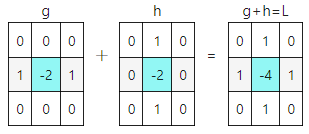

### Cruce por cero

Nótese que tras aplicar ese kernel, **se necesita un algoritmo que detecte los cruces por cero** para devolver una imagen binaria de los bordes. Un ejemplo de un algoritmo simple de cruce por cero:

> 1. Seleccionar un número positivo pequeño (umbral) $th$.
> 2. Un píxel se etiqueta como borde si en la imagen laplaciana
> - su valor es menor que $-th$ y al menos uno de sus vecinos es mayor que $th$, o
> - su valor es mayor que $th$ y al menos uno de sus vecinos es menor que $-th$.

### Limitaciones

Desafortunadamente, el operador Laplaciano es muy sensible al ruido, lo que resulta en una mala detección de bordes. Solución: Si la imagen se filtra utilizando un filtro gaussiano antes de aplicar el operador de Laplace, podemos resolver parcialmente el problema del ruido. En este caso, se denomina **LoG (Laplaciano del Gaussiano)**.

## Operador LoG

Así, el operador LoG primero suaviza la imagen, y luego aplica el operador Laplaciano, al que aplicando las propiedades de convolución se llega:

$$
\nabla^2[f(x,y)\otimes g_\sigma(x,y)]
=
f(x,y) \otimes \nabla^2[g_\sigma(x,y)]
= f(x,y) \otimes LoG_\sigma(x,y)
$$

LoG es un operador isotrópico, es decir, mantiene la simetría radial. De este modo, se supone que la covarianza en ambas dimensiones de la imagen es la misma.

$$LoG_\sigma (x,y) = \frac{1}{\pi \sigma^4}
\left[ \frac{x^2+y^2}{2 \sigma^2} -1 \right] \exp^{-\frac{x^2+y^2}{2 \sigma^2}}
=
\left[ \frac{r^2}{2 \sigma^2} -1 \right] \exp^{-\frac{r^2}{2 \sigma^2}}
= LoG_\sigma(r^2)
$$

**¡Imprimamos el operador LoG!

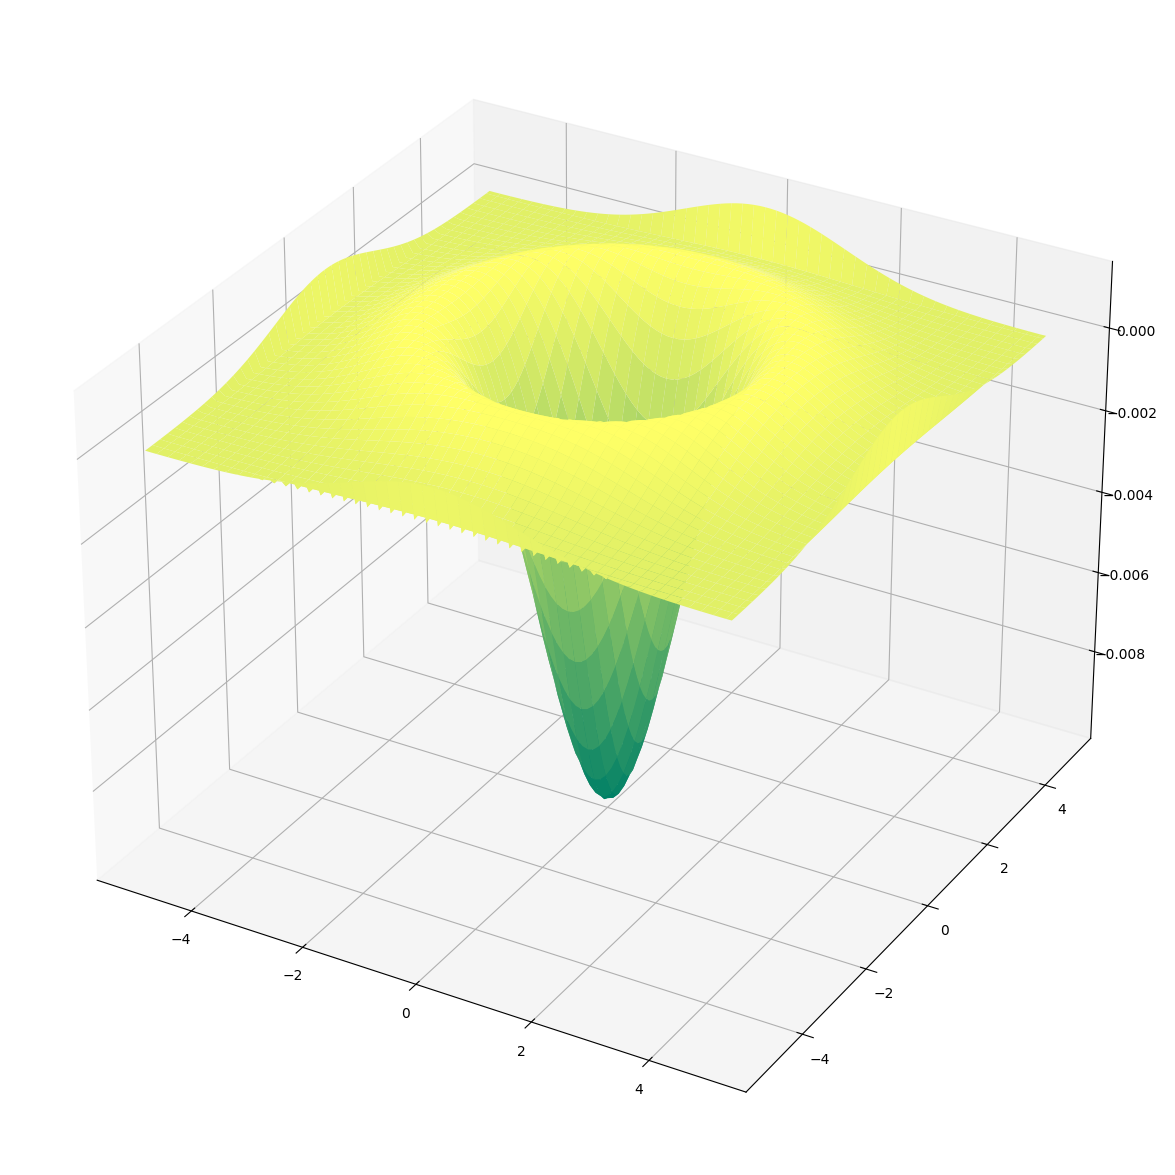

In [30]:
# Filtro Gaussiano
v = np.arange(-5,5,0.1)
X, Y = np.meshgrid(v,v)
covar = np.array([[2, 0],[0, 2]]) ## Assumiendo que no existe correlación entre X e Y
gauss_filter = np.exp(-0.5*(X**2/covar[0][0]+Y**2/covar[1][1]))

# Filtro de Laplace
laplace_filter = np.array(([[0,1,0],[1,-4,1],[0,1,0]]), dtype="float")

# Operador LoG
LoG = cv2.filter2D(gauss_filter, -1, laplace_filter)

# Mostrandolo en un gráfico!
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X,Y,LoG,cmap='summer', edgecolor='none')

Como nota al margen, el LoG no es separable, pero puede implementarse como **DoG (Diferencia de Gaussianos)**, una suma de operadores separables, reduciendo su complejidad de $O(N^2)$ a $O(4N)$:

$$
DoG_{\sigma_1\sigma_2}(x,y) =
g_{\sigma_1}(x,y) - g_{\sigma_2}(x,y) =
g_{\sigma_1}(x)g_{\sigma_1}(y) - g_{\sigma_2}(x) g_{\sigma_2}(y)
$$


Dando la relación $\sigma_1 / \sigma_2 = 1,6$ la mejor aproximación de LoG. Este enfoque de reducción de complejidad se emplea en el detector de puntos clave SIFT.

### Limitaciones

- Es costoso computacionalmente.
- No proporciona información sobre la orientación de los bordes.
- La salida contiene valores negativos y no enteros, por lo que a efectos de visualización la imagen debe normalizarse al rango 0-255.
- Se necesita un método de paso por cero.
- Tiende a redondear las esquinas de los objetos (más fuertemente a medida que $\sigma$ crece).

### Experimentando los operadores Laplaciano y LoG

Ahora que ya somos casi expertos en los operadores Laplaciano y LoG, ¡juguemos un poco con ellos!

### **<span style="color:green"><b><i>Ejercicio 6a: Aplicando el suavizado Gaussiano</i></b></span>**  (2 puntos, por 6a y 6b juntos)

Primero, completa la función `gaussian_smoothing()` que suaviza una imagen usando un filtro Gaussiano. Luego, la normaliza y devuelve la imagen resultante.

In [44]:
# Ejercicio 6a
# Implementa una función que suaviza una imagen de entrada usando un filtro gaussiano y luego la normaliza.
def gaussian_smoothing(image, sigma, w_kernel):
    """ Blur and normalize input image.

        Args:
            image: Input image to be binarized
            sigma: Standard deviation of the Gaussian distribution
            w_kernel: Kernel aperture size

        Returns:
            binarized: Blurred image
    """
    # Define un kernel 1D
    half_size = w_kernel // 2
    x = np.arange(-half_size, half_size + 1)
    g = (1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-(x**2) / (2 * sigma**2))
    g = g / g.sum()  # Normalización del kernel

    # Aplica la propiedad distributiva de la convolución
    blur = cv2.filter2D(image, -1, g.reshape(1, -1))  # Horizontal
    blur = cv2.filter2D(blur, -1, g.reshape(-1, 1))   # Vertical
    # Normaliza a intervalo de valores  [0 255]
    blur_norm = cv2.normalize(blur, None, 0, 255, cv2.NORM_MINMAX)
  

    return blur_norm


Ahora vamos a ver las diferencias entre los operadores de Laplace y LoG.

### **<span style="color:green"><b><i>Ejercicio 6b:Detección de bordes con Laplace y LoG</i></b></span>**

Complete `laplace_testing()` que aplica el operador Laplaciano a la imagen de entrada y a una versión suavizada de la imagen de entrada (utilice la función implementada anteriormente para suavizarla). Muestra ambas imágenes junto con la original en un gráfico de 1x3. Utilice como entradas: una imagen, el tamaño del filtro Laplaciano (debe ser impar), y los parámetros del filtro Gaussiano.

Tenga en cuenta que sería posible reducir el tiempo de cálculo si LoG fuera precalculado. Se trata de convolucionar los filtros Laplace y Gaussiano en lugar de aplicarlos por separado.

*Tip: OpenCV define el operador de Laplace como [cv2.Laplacian()](https://docs.opencv.org/3.4/d5/db5/tutorial_laplace_operator.html)*




In [33]:
# Ejercicio 6b
# Implementar una función que aplique el operador Laplaciano a la imagen de entrada y a una versión suavizada de la misma.
# Muestra un gráfico 1x3 con la imagen original y las dos imágenes de bordes resultantes.
# Entradas: imagen, tamaño del kernel Laplaciano, sigma y tamaño del kernel Gaussiano
def laplace_testing(image, size_Laplacian, sigma, w_gaussian):
    """  Aplica los operadores Laplaciano y Log a una imagen.

        Args:
            image: Imagen de entrada a binarizar
            size_Laplacian: tamaño del kernel laplaciano (impar)
            sigma: desviación estándar de la distribución gaussiana
            w_gaussian: Tamaño de apertura del kernel gaussiano
    """

    # Suavizar la imagen
    image_smooth = gaussian_smoothing(image, sigma, w_gaussian)

    # Aplicar el Laplaciano a la imagen original
    laplace_original = cv2.Laplacian(image, cv2.CV_64F, ksize=size_Laplacian)


    # Aplicar el Laplaciano a la imagen suavizada
    laplace_smooth = cv2.Laplacian(image_smooth, cv2.CV_64F, ksize=size_Laplacian)


    # Mostrar imagen inicial
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    axes[0].imshow(image, cmap='gray')
    axes[0].set_title('Imagen original')
    axes[0].axis('off')

    # Show laplacian
    axes[1].imshow(np.abs(laplace_original), cmap='gray')
    axes[1].set_title('Laplaciano (original)')
    axes[1].axis('off')

    # Mostrar LoG
    axes[2].imshow(np.abs(laplace_smooth), cmap='gray')
    axes[2].set_title('LoG (Laplaciano + suavizado)')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

Es hora de probar este método a nuestras imágenes médicas y jugar con los parámetros interactivos.$\\[5pt]$     

In [ ]:
# Leer una imagen
image = cv2.imread(images_path + 'medical_3.jpg', 0)

# Interactuar con los parámetros!
interactive(laplace_testing, image=fixed(image), size_Laplacian=(1,7,2), sigma=(1,3,0.1), w_gaussian=(1,3,1))

interactive(children=(IntSlider(value=3, description='size_Laplacian', max=7, min=1, step=2), FloatSlider(valu…

### <font color="blue"><b><i>Pensándolo bien (2)</i></b></font>

Ahora, **responde a las siguientes preguntas**:

- ¿Se puede aplicar el Laplaciano sin un suavizado previo?
  
    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Pon tu respuesta aquí!</i></p>
    
- ¿Qué se necesitaría para obtener los bordes de esas imágenes?
  
    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Pon tu respuesta aquí!</i></p>

## 2.3  El algoritmo Canny

El detector de bordes Canny <sup>[[1]](#cite1)</sup> es un algoritmo que aplica el operador DroG , la supresión de no máximos (non-maxima suppression o NMS) y la histéresis (hysteresis) para la detección de bordes en imágenes. Fue diseñado para ser un buen detector, producir una buena localización y proporcionar una única respuesta!.

Este algoritmo consta de los siguientes pasos

1. *Filtrado de ruido*. iltrar cualquier ruido utilizando un filtro gaussiano.$\\[5pt]$

2. *Obtención de la imagen de gradiente*. Aplica el Operador DroG operator.$\\[5pt]$

3. *Non-maximum suppression* Esto elimina los píxeles que no se consideran parte de un borde. Normalmente, la imagen de gradiente obtenida tras utilizar DroG presenta bordes gruesos. La idea es mantener sólo aquellos píxeles que son máximos dentro de su vecindad en la dirección del gradiente, suprimiendo el resto de ellos. De este modo, sólo quedarán las líneas finas (bordes candidatos). Para ello:

     -  Consideramos 4 direcciones principales:  $[0,45]$, $[45,90]$, $[90,135]$, $[135,180]$. El ángulo del gradient [i,j]$  se aproxima por donde se posa.
     - Comprobamos el $G[i,j]$ en los tres puntos a lo largo de la dirección seleccionada, y elegimos el máximo. De esta forma tenemos una única respuesta en cada borde.


<img src="./imagenes/canny_nonmaxima.png" width="800">

<!--
<img src='https://drive.google.com/uc?export=view&id=1u8kF37ystoLp3JMLaDdROAtsKffVP4_5' width="800">
-->
4. *Hysteresis*:  El paso final. Canny utiliza dos umbrales (superior e inferior) para determinar los píxeles de borde:

    - Si el nivel de gris de un píxel candidato de la imagen de gradiente es superior al umbral superior, el píxel se acepta como borde.
    - Si el nivel de gris de un píxel candidato de la imagen de gradiente es inferior al umbral inferior, se rechaza.
    - Si el nivel de gris de un píxel candidato de la imagen de gradiente está entre los dos umbrales, entonces será aceptado sólo si está conectado a un píxel que está por encima del umbral superior y rechazado en caso contrario.

 
<img src="./imagenes/hysteresis.png" width="800">

<!--  
<img src='https://drive.google.com/uc?export=view&id=1jDhV-augcs22fxtVsHOfcO4tq4dsbSBd' width="800">
-->

El algoritmo puede repetirse con diferente nivel de suavizado (cambiando el sigma del operador DroG). Diferentes sigma producen bordes en diferentes características espaciales.

### **<span style="color:green"><b><i>Ejercicio 7: El enormemente popular Algoritmo de Canny</i></b></span>**  (1.25 puntos)

Completa `canny_testing()`, que aplica el algoritmo de Canny a una imagen y a una versión suavizada de la misma *(ten en cuenta que la implementación de Canny de OpenCV no aplica el suavizado gaussiano)*. Luego ambas se muestran junto a la imagen original. Toma como entrada una imagen, los umbrales Canny inferior y superior, y los parámetros del filtro gaussiano.

*Nota: usa `gaussian_smoothing` para desenfocar la imagen.*

*Tip: OpenCV define el algoritmo Canny como [cv2.Canny()](https://docs.opencv.org/2.4/modules/imgproc/doc/feature_detection.html?highlight=canny)*

In [35]:
# ASSIGNMENT 7
# Implementar una función que aplique el operador Canny a una imagen de entrada y a una versión desenfocada de la misma.
# Muestra un gráfico 1x3 con la imagen original y las dos imágenes de bordes resultantes.
# Entradas: imagen, tamaño del kernel Laplaciano, sigma y tamaño del kernel Gaussiano
def canny_testing(image, lower_threshold, upper_threshold, sigma, w_gaussian):
    """ Aplica el algoritmo Canny a una imagen.

        Args:
            image: Imagen de entrada a binarizar
            lower_threshold: valor inferior de la histéresis
            upper_threshold: valor superior de la histéresis
            sigma: desviación estándar de la distribución gaussiana
            w_gaussian: Tamaño de apertura del kernel gaussiano
    """

    # Desenfocar imagen
    blurred = gaussian_smoothing(image, sigma, w_gaussian)

    # Aplicar Canny a la imagen original
    canny_original = cv2.Canny(image, lower_threshold, upper_threshold)

    # Aplicar Canny a la imagen suavizada
    canny_blurred = cv2.Canny(blurred, lower_threshold, upper_threshold)

    # Mostrar imagen inicial
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Imagen Original')
    plt.axis('off')

    # Mostrar Canny sin desenfoque
    plt.subplot(1, 3, 2)
    plt.imshow(canny_original, cmap='gray')
    plt.title('Canny sin suavizar')
    plt.axis('off')

    # Mostrar Canny con desenfoque
    plt.subplot(1, 3, 3)
    plt.imshow(canny_blurred, cmap='gray')
    plt.title('Canny con suavizado')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

Entre los múltiples parámetros de este algoritmo, es interesante comprobar su rendimiento con distintos niveles de suavizado (cambiando el sigma del operador DroG). Diferentes sigma producen bordes en diferentes características espaciales. **Pruebe el efecto de este y otros parámetros** jugando con parámetros interactivos.$\\[5pt]$      


In [ ]:
# Leer una imagen
image = cv2.imread(images_path + 'medical_2.jpg', 0)

# Interactuar con los parámetros
interactive(canny_testing, image=fixed(image), lower_threshold=(0,260,20), upper_threshold=(0,260,20), sigma=(1,3,0.1), w_gaussian=(1,3,1))

interactive(children=(IntSlider(value=120, description='lower_threshold', max=260, step=20), IntSlider(value=1…

### <font color="blue"><b><i>Pensándolo bien (2)</i></b></font>

Ahora, **responde a las siguientes preguntas**:

- ¿Se puede aplicar Canny sin un suavizado previo?
  
    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Pon tu respuesta aquí!</i></p>    
- ¿Cuál es un valor *bueno* para ambos umbrales?
  
    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Pon tu respuesta aquí!</i></p>
    
- Ahora que has probado un buen número de métodos de detección de bordes, **¿cuál es tu favorito y por qué?**.

    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Pon tu respuesta aquí!</i></p>

### **<span style="color:green"><b><i>Ejercicio 8: El Filtrado bilateral</i></b></span>**  (1.5 puntos)

Usa la funcion ``cv2.bilateralFilter()`` de OpenCV p para llevar a cabo el filtrado bilateral de una imagen. Selecciona cuidadosamente los parámetros apropiados y aplícalo tanto a las imágenes ``sillagauss.bmp`` y ``sillaimp.bmp``, así como a otras de tu elección.

En el contexto del filtrado bilateral,  $\sigma_r$ a la varianza de la gaussiana que controla la ponderación debida a la diferencia entre los valores de los píxeles, mientras que $\sigma_s$ a la varianza de la gaussiana que controla la ponderación debida a la posición de los píxeles. A continuación, se plantean algunas interrogantes:
* ¿¿Cuál es el comportamiento del filtro bilateral cuando la varianza $\sigma_r$ es muy elevada? ¿En este caso qué ocurre si $\sigma_s$ es alta o baja?
* ¿Cómo se comporta el filtro cuando $\sigma_r$ es muy baja? ¿En este caso cómo se comporta el filtro dependiendo si $\sigma_s$ es alta o baja?

Se espera que se muestren y discutan los resultados obtenidos al variar los valores de los parámetros y al aplicar el filtro sucesivamente en múltiples ocasiones. Compáralos con los obtenidos usando el filtro gaussiano para evaluar su efectividad en la mejora de la calidad de las imágenes.

In [39]:
def bilateral_filtering(sigmaColor, sigmaSpace):
    # Cargar imágenes
    img1 = cv2.imread('imagenes/sillagauss.bmp', cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread('imagenes/sillaimp.bmp', cv2.IMREAD_GRAYSCALE)

    # Aplicar filtro bilateral a ambas imágenes
    filtered1 = cv2.bilateralFilter(img1, d=9, sigmaColor=sigmaColor, sigmaSpace=sigmaSpace)
    filtered2 = cv2.bilateralFilter(img2, d=9, sigmaColor=sigmaColor, sigmaSpace=sigmaSpace)

    # Mostrar resultados
    fig, axes = plt.subplots(2, 2, figsize=(12, 6))
    axes[0, 0].imshow(img1, cmap='gray')
    axes[0, 0].set_title('Original Gaussiana')
    axes[0, 1].imshow(filtered1, cmap='gray')
    axes[0, 1].set_title(f'Filtrada Gaussiana\nσᵣ={sigmaColor}, σₛ={sigmaSpace}')


    axes[1, 0].imshow(img2, cmap='gray')
    axes[1, 0].set_title('Original Impulsiva')
    axes[1, 1].imshow(filtered2, cmap='gray')
    axes[1, 1].set_title(f'Filtrada Impulsiva\nσᵣ={sigmaColor}, σₛ={sigmaSpace}')
  

    for ax in axes.ravel():
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Control interactivo
interactive(bilateral_filtering, sigmaColor=(1, 150, 5), sigmaSpace=(1, 150, 5))

interactive(children=(IntSlider(value=71, description='sigmaColor', max=150, min=1, step=5), IntSlider(value=7…

### **<span style="color:green"><b><i>Ejercicio 9: Transformada Hough</i></b></span>**  (1.5 puntos)

Emplea la transformada Hough para encontrar segmentos rectilíneos en la imagen ``pasillo.jpg``. Para extraer los bordes de la imagen puedes utilizar las funciones escritas en las secciones anteriores o usar algunas de las funciones que tiene opencv para extraer bordes (por ejemplo ``cv2.Canny``. Si usas esta función de openCV como ``cv2.Canny`` explica por qué pusiste los  valores de los parámetros que empleaste.) Utiliza la función ``cv2.HoughLinesP()`` de OpenCV.

Es fundamental realizar un análisis exhaustivo del rendimiento del algoritmo para diferentes valores de los parámetros de la función de transformada de Hough, así como para evaluar los efectos de los filtros utilizados en la extracción de bordes. Discute estos resultados. Pinta los resultados sobre la imagen (puedes guiarte como ejemplo de lo mostrado en, https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_houghlines/py_houghlines.html).

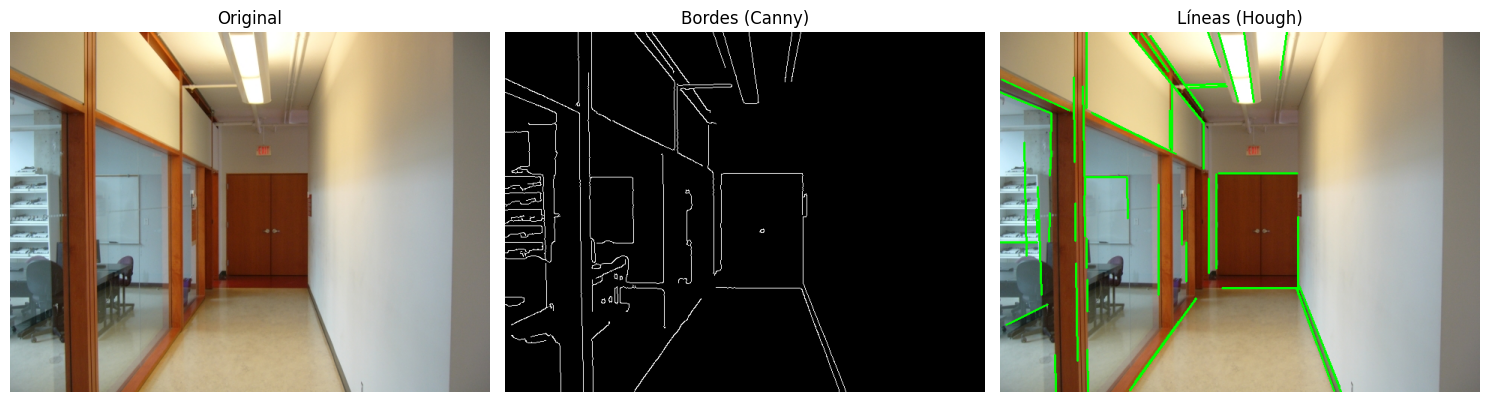

In [49]:
# Cargar imagen en escala de grises
image = cv2.imread('imagenes/pasillo.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Aplicar desenfoque gaussiano para reducir el ruido
blurred = cv2.GaussianBlur(gray, (5, 5), 1.5)

# Aplicar Canny para extraer bordes
edges = cv2.Canny(blurred, threshold1=50, threshold2=150)

# Aplicar la transformada de Hough probabilística
lines = cv2.HoughLinesP(edges, rho=1, theta=np.pi/180, threshold=50,
                        minLineLength=30, maxLineGap=10)

# Dibujar líneas sobre una copia de la imagen original
image_lines = image.copy()
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(image_lines, (x1, y1), (x2, y2), (0, 255, 0), 2)

# Mostrar resultados
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title("Original")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Bordes (Canny)")
plt.imshow(edges, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Líneas (Hough)")
plt.imshow(cv2.cvtColor(image_lines, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.tight_layout()
plt.show()

## Conclusion

¡Perfecto! Ahora tienes experiencia en más aplicaciones del operador de convolución. En este Notebook tú:

- Aprendiste operadores básicos para la detección de bordes que realizan una **aproximación discreta de un operador de gradiente**.
- Aprendiste **cómo construir un kernel DroG** de manera eficiente.
- Experimentado un poco con ellos en el contexto de las imágenes médicas, descubriendo algunas utilidades reales e importantes.
- Los operadores de Laplace y LoG y la importancia del suavizado.
- cómo utilizar el algoritmo de Canny, y cómo se implementa.

## Extra

El algoritmo Canny es un algoritmo muy conocido en este campo, se utiliza en muchas tecnologías actuales. Aunque sigue obteniendo muy buenos resultados, el artículo original fue publicado en 1986 por John Canny<sup>[[1]](#cite1)</sup>.

## Referencias

<a name="myfootnote1">[1]</a>: CANNY, John. [A computational approach to edge detection.](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=10&ved=2ahUKEwiU9uyiganoAhWNDWMBHducCvsQFjAJegQIBhAB&url=http%3A%2F%2Fciteseerx.ist.psu.edu%2Fviewdoc%2Fdownload%3Fdoi%3D10.1.1.420.3300%26rep%3Drep1%26type%3Dpdf&usg=AOvVaw3tsKoxnc3qnS7bji3HmvQc). IEEE Transactions on pattern analysis and machine intelligence, 1986, no 6, p. 679-698.